In [281]:
import sympy as sym
from sympy import Matrix
import math

from mitroiki_functs import K_with_axial
from mitroiki_functs import TranformMatrix
from mitroiki_functs import round_expr
from mitroiki_functs import P_uniformly_distributed_load

import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt

from IPython.display import Image

# Εφαρμογή 8 - Χρήση μητρώων μετασχηματισμού σε μη ορθογωνικό φορέα

Να υπολογιστούν οι αντιδράσεις στήριξης, οι παραμορφώσεις και τα διαγράμματα των εντατικών μεγεθών για τον φορέα του σχήματος.

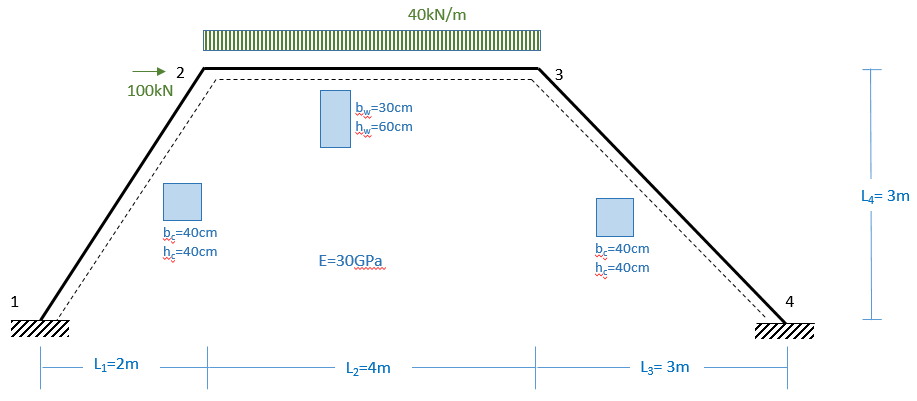

In [316]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example8/ekfonisi.png", width=800)

In [283]:
E = 30_000_000.

bw = 0.30
hw = 0.60

bc = 0.40
hc = 0.40

Iw = bw * hw**3 / 12
Aw = bw * hw

Ic = bc * hc**3 / 12
Ac = bc * hc

L1 = 2.0
L2 = 4.0
L3 = 3.0
L4 = 3.0

F2 = 100.
q = 40.

## Αντιστοίχιση τοπικών - καθολικών βαθμών ελευθερίας

| Καθολ. Συστ. | (1) | (2) | (3) | (4) | (5) | (6) | (7) | (8) | (9) | (10) | (11) | (12) |
|--------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|------|------|------|
| 1-2          |  1  |  2  |  3  |  4  |  5  |  6  |     |     |     |      |      |      |
| 2-3          |     |     |     |  1  |  2  |  3  |  4  |  5  |  6  |      |      |      |
| 3-4          |     |     |     |     |     |     |  1  |  2  |  3  |  4   |  5   |  6   |

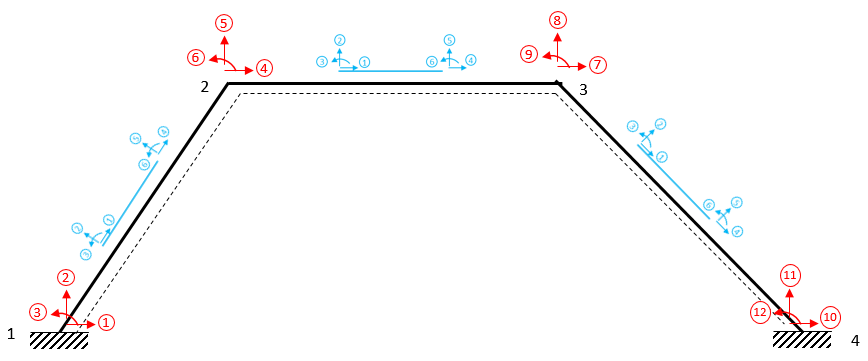

In [318]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example8/dof_global_local.png", width=750)

<!-- ## Αντιστοίχιση τοπικών - καθολικών βαθμών ελευθερίας

| Καθολ. Συστ. | (1) | (2) | (3) | (4) | (5) | (6) | (7) | (8) | (9) | (10) | (11) | (12) |
|--------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|------|------|------|
| 1-2          | -2  |  1  |  3  | -5  |  4  |  6  |     |     |     |      |      |      |
| 2-3          |     |     |     |  1  |  2  |  3  |  4  |  5  |  6  |      |      |      |
| 3-4          |     |     |     |     |     |     |  2  | -1  |  3  |  5   | -4   |  6   | -->

## Μητρώα στιβαρότητας στοιχείων

Τα μήκη των στοιχείων υπολογίζονται ως εξής:

In [284]:
L12 = math.sqrt(L1**2+L4**2)
L23 = L2
L34 = math.sqrt(L3**2+L4**2)
print(f'L12 = {L12:.3f}m')
print(f'L23 = {L23:.3f}m')
print(f'L34 = {L34:.3f}m')

L12 = 3.606m
L23 = 4.000m
L34 = 4.243m


In [285]:
K1 = K_with_axial(E=E, A=Ac, I=Ic, L=L12)
round_expr(K1, 1)

Matrix([
[ 1331280.5,        0,        0, -1331280.5,        0,        0],
[         0,  16385.0,  29538.5,          0, -16385.0,  29538.5],
[         0,  29538.5,  71001.6,          0, -29538.5,  35500.8],
[-1331280.5,        0,        0,  1331280.5,        0,        0],
[         0, -16385.0, -29538.5,          0,  16385.0, -29538.5],
[         0,  29538.5,  35500.8,          0, -29538.5,  71001.6]])

In [286]:
K2 = K_with_axial(E=E, A=Aw, I=Iw, L=L23)
round_expr(K2, 1)

Matrix([
[ 1350000.0,        0,        0, -1350000.0,        0,        0],
[         0,  30375.0,  60750.0,          0, -30375.0,  60750.0],
[         0,  60750.0, 162000.0,          0, -60750.0,  81000.0],
[-1350000.0,        0,        0,  1350000.0,        0,        0],
[         0, -30375.0, -60750.0,          0,  30375.0, -60750.0],
[         0,  60750.0,  81000.0,          0, -60750.0, 162000.0]])

In [287]:
K3 = K_with_axial(E=E, A=Ac, I=Ic, L=L34)
round_expr(K3, 1)

Matrix([
[ 1131370.8,        0,        0, -1131370.8,        0,        0],
[         0,  10056.6,  21333.3,          0, -10056.6,  21333.3],
[         0,  21333.3,  60339.8,          0, -21333.3,  30169.9],
[-1131370.8,        0,        0,  1131370.8,        0,        0],
[         0, -10056.6, -21333.3,          0,  10056.6, -21333.3],
[         0,  21333.3,  30169.9,          0, -21333.3,  60339.8]])

## Μητρώα μετασχηματισμού και μετατροπή των μητρώων στιβαρότητας

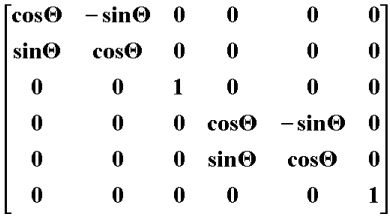

In [319]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/trans_matrix.png", width=230)

Το στοιχείο 1 σχηματίζει γωνία $θ_1$ μοιρών με το καθολικό σύστημα συντεταγμένων, ενώ το στοιχείο 3 γωνία $θ_3$. 

Προφανώς η γωνία για το στοιχείο 2 είναι 0 (οριζόντιο).

In [289]:
θ1 = math.atan(L4/L1)
print(f'θ1 = {θ1:.4f}rad = {θ1*180/math.pi:.2f}μοίρες')

θ1 = 0.9828rad = 56.31μοίρες


In [290]:
θ3 = -math.atan(L4/L3)
print(f'θ3 = {θ3:.4f}rad = {θ3*180/math.pi:.2f}μοίρες')

θ3 = -0.7854rad = -45.00μοίρες


In [291]:
Λ1 = TranformMatrix(θ1)
Λ1

Matrix([
[0.554700196225229, -0.832050294337844, 0,                 0,                  0, 0],
[0.832050294337844,  0.554700196225229, 0,                 0,                  0, 0],
[                0,                  0, 1,                 0,                  0, 0],
[                0,                  0, 0, 0.554700196225229, -0.832050294337844, 0],
[                0,                  0, 0, 0.832050294337844,  0.554700196225229, 0],
[                0,                  0, 0,                 0,                  0, 1]])

In [292]:
K1_trans = Λ1 * K1 * Λ1.transpose()
round_expr(K1_trans, 1)

Matrix([
[ 420968.2,  606874.8, -24577.5, -420968.2, -606874.8, -24577.5],
[ 606874.8,  926697.2,  16385.0, -606874.8, -926697.2,  16385.0],
[ -24577.5,   16385.0,  71001.6,   24577.5,  -16385.0,  35500.8],
[-420968.2, -606874.8,  24577.5,  420968.2,  606874.8,  24577.5],
[-606874.8, -926697.2, -16385.0,  606874.8,  926697.2, -16385.0],
[ -24577.5,   16385.0,  35500.8,   24577.5,  -16385.0,  71001.6]])

In [293]:
Λ3 = TranformMatrix(θ3)
round_expr(Λ3, 4)

Matrix([
[ 0.7071, 0.7071, 0,       0,      0, 0],
[-0.7071, 0.7071, 0,       0,      0, 0],
[      0,      0, 1,       0,      0, 0],
[      0,      0, 0,  0.7071, 0.7071, 0],
[      0,      0, 0, -0.7071, 0.7071, 0],
[      0,      0, 0,       0,      0, 1]])

In [294]:
K3_trans = Λ3 * K3 * Λ3.transpose()
round_expr(K3_trans, 1)

Matrix([
[ 570713.7, -560657.1,  15084.9, -570713.7,  560657.1,  15084.9],
[-560657.1,  570713.7,  15084.9,  560657.1, -570713.7,  15084.9],
[  15084.9,   15084.9,  60339.8,  -15084.9,  -15084.9,  30169.9],
[-570713.7,  560657.1, -15084.9,  570713.7, -560657.1, -15084.9],
[ 560657.1, -570713.7, -15084.9, -560657.1,  570713.7, -15084.9],
[  15084.9,   15084.9,  30169.9,  -15084.9,  -15084.9,  60339.8]])

## Μητρώο στιβαρότητας φορέα
Είναι διαστάσεων 12x12 και δημιουργείται από το συνδυασμό των επιμέρους μητρώων, βάσει της αντιστοίχισης των βαθμών ελευθερίας στο καθολικό σύστημα συντεταγμένων

Δημιουργείται ένα μηδενικό μητρώο 12x12 και σταδιακά προστίθενται οι τιμές στις κατάλληλες θέσεις

| Καθολ. Συστ. | (1) | (2) | (3) | (4) | (5) | (6) | (7) | (8) | (9) | (10) | (11) | (12) |
|--------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|------|------|------|
| 1-2          |  1  |  2  |  3  |  4  |  5  |  6  |     |     |     |      |      |      |
| 2-3          |     |     |     |  1  |  2  |  3  |  4  |  5  |  6  |      |      |      |
| 3-4          |     |     |     |     |     |     |  1  |  2  |  3  |  4   |  5   |  6   |

In [295]:
K1_temp = sym.zeros(12,12)
K1_temp[:6, :6] += K1_trans
round_expr(K1_temp, 1)

Matrix([
[ 420968.2,  606874.8, -24577.5, -420968.2, -606874.8, -24577.5, 0, 0, 0, 0, 0, 0],
[ 606874.8,  926697.2,  16385.0, -606874.8, -926697.2,  16385.0, 0, 0, 0, 0, 0, 0],
[ -24577.5,   16385.0,  71001.6,   24577.5,  -16385.0,  35500.8, 0, 0, 0, 0, 0, 0],
[-420968.2, -606874.8,  24577.5,  420968.2,  606874.8,  24577.5, 0, 0, 0, 0, 0, 0],
[-606874.8, -926697.2, -16385.0,  606874.8,  926697.2, -16385.0, 0, 0, 0, 0, 0, 0],
[ -24577.5,   16385.0,  35500.8,   24577.5,  -16385.0,  71001.6, 0, 0, 0, 0, 0, 0],
[        0,         0,        0,         0,         0,        0, 0, 0, 0, 0, 0, 0],
[        0,         0,        0,         0,         0,        0, 0, 0, 0, 0, 0, 0],
[        0,         0,        0,         0,         0,        0, 0, 0, 0, 0, 0, 0],
[        0,         0,        0,         0,         0,        0, 0, 0, 0, 0, 0, 0],
[        0,         0,        0,         0,         0,        0, 0, 0, 0, 0, 0, 0],
[        0,         0,        0,         0,         0,        0, 0,

In [296]:
K2_temp = sym.zeros(12,12)
K2_temp[3:9, 3:9] += K2
round_expr(K2_temp, 1)

Matrix([
[0, 0, 0,          0,        0,        0,          0,        0,        0, 0, 0, 0],
[0, 0, 0,          0,        0,        0,          0,        0,        0, 0, 0, 0],
[0, 0, 0,          0,        0,        0,          0,        0,        0, 0, 0, 0],
[0, 0, 0,  1350000.0,        0,        0, -1350000.0,        0,        0, 0, 0, 0],
[0, 0, 0,          0,  30375.0,  60750.0,          0, -30375.0,  60750.0, 0, 0, 0],
[0, 0, 0,          0,  60750.0, 162000.0,          0, -60750.0,  81000.0, 0, 0, 0],
[0, 0, 0, -1350000.0,        0,        0,  1350000.0,        0,        0, 0, 0, 0],
[0, 0, 0,          0, -30375.0, -60750.0,          0,  30375.0, -60750.0, 0, 0, 0],
[0, 0, 0,          0,  60750.0,  81000.0,          0, -60750.0, 162000.0, 0, 0, 0],
[0, 0, 0,          0,        0,        0,          0,        0,        0, 0, 0, 0],
[0, 0, 0,          0,        0,        0,          0,        0,        0, 0, 0, 0],
[0, 0, 0,          0,        0,        0,          0,        0,    

In [297]:
K3_temp = sym.zeros(12,12)
K3_temp[6:, 6:] += K3_trans
round_expr(K3_temp, 1)

Matrix([
[0, 0, 0, 0, 0, 0,         0,         0,        0,         0,         0,        0],
[0, 0, 0, 0, 0, 0,         0,         0,        0,         0,         0,        0],
[0, 0, 0, 0, 0, 0,         0,         0,        0,         0,         0,        0],
[0, 0, 0, 0, 0, 0,         0,         0,        0,         0,         0,        0],
[0, 0, 0, 0, 0, 0,         0,         0,        0,         0,         0,        0],
[0, 0, 0, 0, 0, 0,         0,         0,        0,         0,         0,        0],
[0, 0, 0, 0, 0, 0,  570713.7, -560657.1,  15084.9, -570713.7,  560657.1,  15084.9],
[0, 0, 0, 0, 0, 0, -560657.1,  570713.7,  15084.9,  560657.1, -570713.7,  15084.9],
[0, 0, 0, 0, 0, 0,   15084.9,   15084.9,  60339.8,  -15084.9,  -15084.9,  30169.9],
[0, 0, 0, 0, 0, 0, -570713.7,  560657.1, -15084.9,  570713.7, -560657.1, -15084.9],
[0, 0, 0, 0, 0, 0,  560657.1, -570713.7, -15084.9, -560657.1,  570713.7, -15084.9],
[0, 0, 0, 0, 0, 0,   15084.9,   15084.9,  30169.9,  -15084.9,  -150

Οπότε το συνολικό μητρώο του φορέα είναι το $Κ$

In [298]:
K = K1_temp + K2_temp + K3_temp
round_expr(K, 1)

Matrix([
[ 420968.2,  606874.8, -24577.5,  -420968.2, -606874.8, -24577.5,          0,         0,        0,         0,         0,        0],
[ 606874.8,  926697.2,  16385.0,  -606874.8, -926697.2,  16385.0,          0,         0,        0,         0,         0,        0],
[ -24577.5,   16385.0,  71001.6,    24577.5,  -16385.0,  35500.8,          0,         0,        0,         0,         0,        0],
[-420968.2, -606874.8,  24577.5,  1770968.2,  606874.8,  24577.5, -1350000.0,         0,        0,         0,         0,        0],
[-606874.8, -926697.2, -16385.0,   606874.8,  957072.2,  44365.0,          0,  -30375.0,  60750.0,         0,         0,        0],
[ -24577.5,   16385.0,  35500.8,    24577.5,   44365.0, 233001.6,          0,  -60750.0,  81000.0,         0,         0,        0],
[        0,         0,        0, -1350000.0,         0,        0,  1920713.7, -560657.1,  15084.9, -570713.7,  560657.1,  15084.9],
[        0,         0,        0,          0,  -30375.0, -60750.0,  

## Μητρώο εξωτερικής φόρτισης

Η εξωτερική φόρτιση αποτελείται από το επικόμβιο φορτίο στον κόμβο 2 και και το κατανεμημένο φορτίο στο στοιχείο 2.

Παρατηρείται ότι στο καθολικό σύστημα συντεταγμένων τα φορτία αυτά έχουν όλα θετικό πρόσημο, εκτός από τη ροπή στον κόμβο 2.

In [299]:
P_q = P_uniformly_distributed_load(q=q, L=L23, ignore_axial=False)
P_q

Matrix([
[                0],
[            -80.0],
[-53.3333333333333],
[                0],
[            -80.0],
[ 53.3333333333333]])

In [300]:
P = Matrix([[0],
            [0],
            [0],
            [F2],
            [0],
            [0],
            [0],
            [0],
            [0],
            [0],
            [0],
            [0]])

P[3:9, 0] += P_q

round_expr(P, 2)

Matrix([
[     0],
[     0],
[     0],
[ 100.0],
[ -80.0],
[-53.33],
[     0],
[ -80.0],
[ 53.33],
[     0],
[     0],
[     0]])

## Δεσμευμένοι και ελεύθεροι βαθμοί ελευθερίας

Οι δεσμευμένοι βαθμοί ελευθερίας (με κόκκινο) οφείλονται στις πακτώσεις στους κόμβους 1 και 4, ενώ οι βαθμοί ελευθερίας 4-9 είναι αδέσμευτοι.

## Διαχωρισμός μητρώων

| Καθολ. Συστ. | <span style="color:red">(1)</span>  | <span style="color:red">(2)</span> | <span style="color:red">(3)</span> | <span style="color:blue">(4)</span>  | <span style="color:blue">(5)</span>  | <span style="color:blue">(6)</span>  | <span style="color:blue">(7)</span> | <span style="color:blue">(8)</span>  | <span style="color:blue">(9)</span>  | <span style="color:red">(10)</span>  | <span style="color:red">(11)</span>  | <span style="color:red">(12)</span>  |
|--------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|------|------|------|
| 1-2          |  1  |  2  |  3  |  4  |  5  |  6  |     |     |     |      |      |      |
| 2-3          |     |     |     |  1  |  2  |  3  |  4  |  5  |  6  |      |      |      |
| 3-4          |     |     |     |     |     |     |  1  |  2  |  3  |  4   |  5   |  6   |


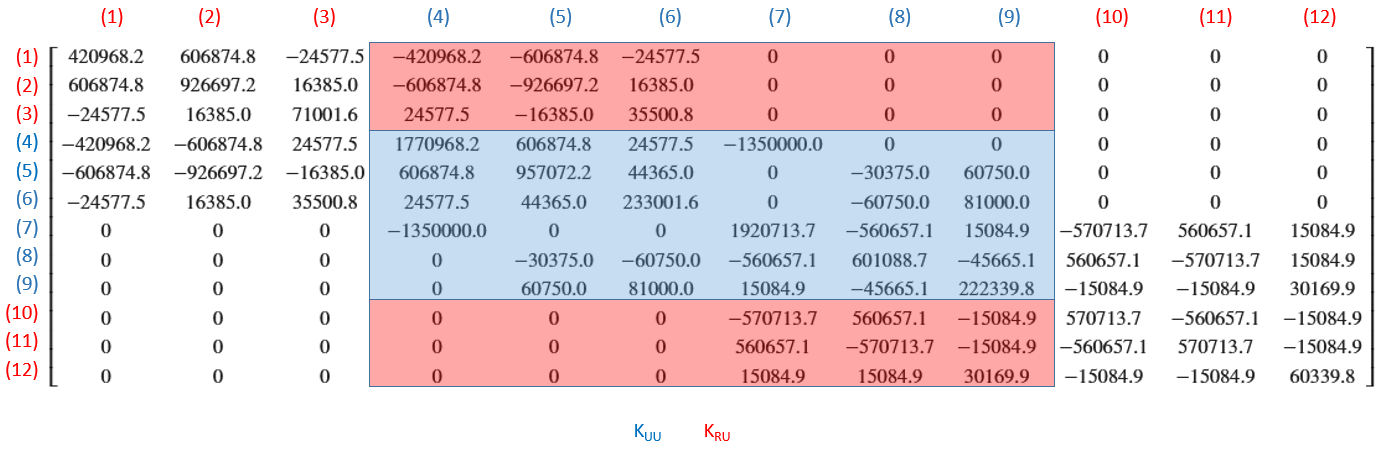

In [320]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example8/Kuu_vs_Kru.png", width=1100)

Ομοίως και για τα μητρώα εξωτερικής φόρτισης, παραμορφώσεων και αντιδράσεων
<!-- <img src="img\PUR.png" width="750"> -->

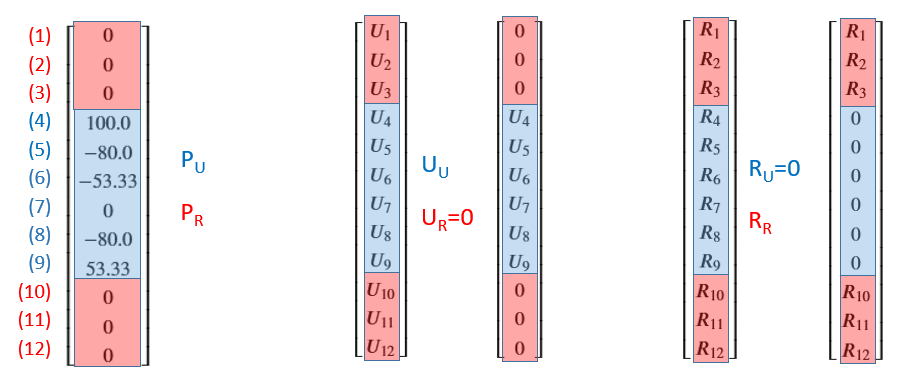

In [321]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example8/PUR.png", width=700)

### Υπομητρώα στιβαρότητας

In [303]:
K_UU = K[[3,4,5,6,7,8], [3,4,5,6,7,8]]
round_expr(K_UU, 1)

Matrix([
[ 1770968.2, 606874.8,  24577.5, -1350000.0,         0,        0],
[  606874.8, 957072.2,  44365.0,          0,  -30375.0,  60750.0],
[   24577.5,  44365.0, 233001.6,          0,  -60750.0,  81000.0],
[-1350000.0,        0,        0,  1920713.7, -560657.1,  15084.9],
[         0, -30375.0, -60750.0,  -560657.1,  601088.7, -45665.1],
[         0,  60750.0,  81000.0,    15084.9,  -45665.1, 222339.8]])

Παρατηρείται ότι το μητρώο $K_{UU}$ στην περίπτωσή μας είναι απλά ένας αριθμος

In [304]:
K_RU = K[[0, 1, 2, 9, 10, 11], [3,4,5,6,7,8]]
round_expr(K_RU, 1)

Matrix([
[-420968.2, -606874.8, -24577.5,         0,         0,        0],
[-606874.8, -926697.2,  16385.0,         0,         0,        0],
[  24577.5,  -16385.0,  35500.8,         0,         0,        0],
[        0,         0,        0, -570713.7,  560657.1, -15084.9],
[        0,         0,        0,  560657.1, -570713.7, -15084.9],
[        0,         0,        0,   15084.9,   15084.9,  30169.9]])

### Υπομητρώα εξωτερικής φόρτισης

In [305]:
P_U = P[[3,4,5,6,7,8], 0]
round_expr(P_U, 2)

Matrix([
[ 100.0],
[ -80.0],
[-53.33],
[     0],
[ -80.0],
[ 53.33]])

In [306]:
P_R = P[[0, 1, 2, 9, 10, 11], 0]
round_expr(P_R, 2)

Matrix([
[0],
[0],
[0],
[0],
[0],
[0]])

## Υπολογισμός παραμορφώσεων

Είναι $K_{UU}\cdot U_U = P_U + R_U$, με $R_U=0$

οπότε $K_{UU}\cdot U_U = P_U$

και τελικά $U_U = K_{UU}^{-1}\cdot P_U$

In [307]:
U_U = K_UU.inv() * P_U
round_expr(U_U, 7)

Matrix([
[ 0.0008829],
[-0.0006499],
[-0.0002446],
[ 0.0007876],
[ 0.0005875],
[ 0.0005738]])

## Υπολογισμός αντιδράσεων στήριξης

Είναι $K_{RU}\cdot U_U = P_R + R_R$

οπότε $R_R = K_{RU}\cdot U_U - P_R$

In [308]:
R_R = K_RU*U_U - P_R
round_expr(R_R, 2)

Matrix([
[  28.73],
[  62.41],
[  23.67],
[-128.73],
[  97.59],
[  38.05]])

## Επίλυση/έλεγχος με το OpenSees

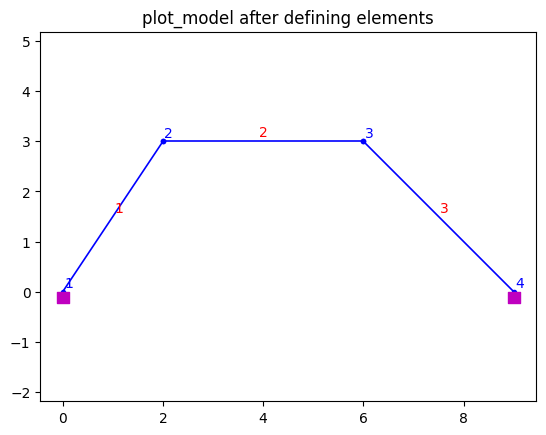

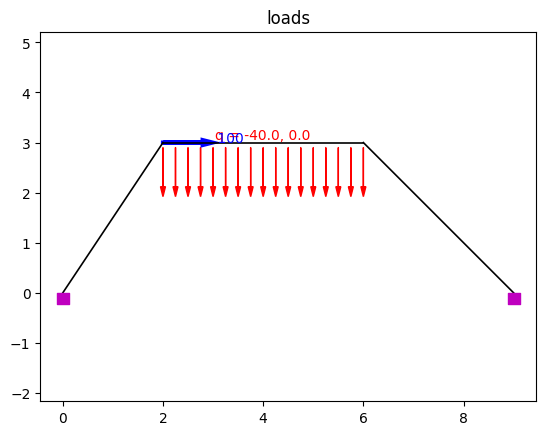

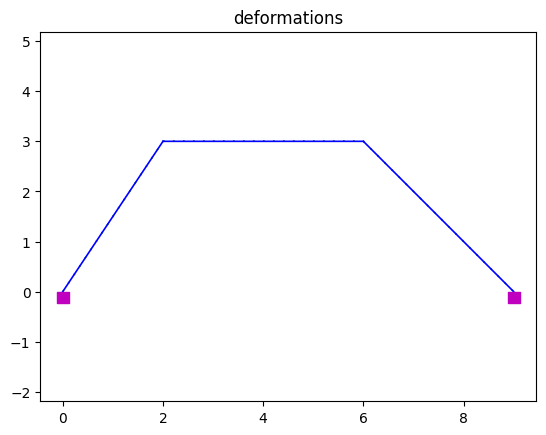

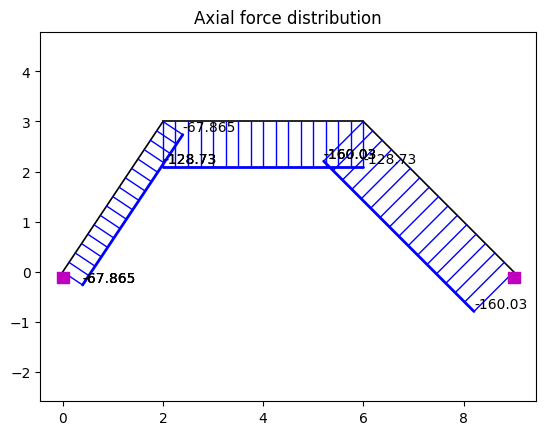

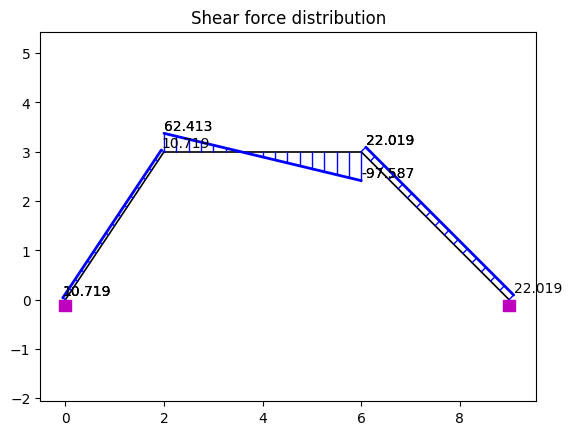

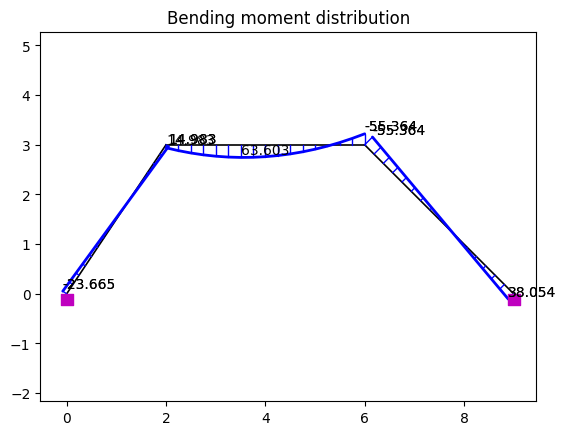

In [309]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

ops.node(1, 0., 0)
ops.node(2, L1, L4)
ops.node(3, L1+L2, L4)
ops.node(4, L1+L2+L3, 0)

ops.fix(1, 1, 1, 1)
ops.fix(4, 1, 1, 1)

# opsv.plot_model()
# plt.title('plot_model before defining elements')

ops.geomTransf('Linear', 1)

# elements
ops.element('elasticBeamColumn', 1, 1, 2, Ac, E, Ic, 1)
ops.element('elasticBeamColumn', 2, 2, 3, Aw, E, Iw, 1)
ops.element('elasticBeamColumn', 3, 3, 4, Ac, E, Ic, 1)


# loads
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)

ops.load(2, F2, 0, 0)
ops.eleLoad('-ele', 2, '-type', '-beamUniform', -q)



# analysis
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

# results
# ops.printModel()
opsv.plot_model()
plt.title('plot_model after defining elements')

opsv.plot_loads_2d()
plt.title('loads')

sfac = .1
opsv.plot_defo(sfac)
plt.title('deformations')

sfacN, sfacV, sfacM = 7.e-3, 6.e-3, 4.e-3
opsv.section_force_diagram_2d('N', sfacN)
plt.title('Axial force distribution')

opsv.section_force_diagram_2d('T', sfacV)
plt.title('Shear force distribution')

opsv.section_force_diagram_2d('M', sfacM)
plt.title('Bending moment distribution')


plt.show()


In [310]:
round_expr(R_R, 2)

Matrix([
[  28.73],
[  62.41],
[  23.67],
[-128.73],
[  97.59],
[  38.05]])

In [311]:
ops.basicDeformation(2)

[-9.535260145159831e-05, -0.0005539171030441442, 0.0002644226960102744]

In [312]:
for i in range(1,5):
    print(ops.nodeReaction(i))

[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]


In [313]:
for i in range(1,5):
    print(ops.nodeDisp(i))

[0.0, 0.0, 0.0]
[0.0008829073159377894, -0.0006498721242716333, -0.0002445689288422502]
[0.0007875547144861911, 0.0005875205725359427, 0.0005737708702121684]
[0.0, 0.0, 0.0]


In [314]:
round_expr(U_U, 7)

Matrix([
[ 0.0008829],
[-0.0006499],
[-0.0002446],
[ 0.0007876],
[ 0.0005875],
[ 0.0005738]])